In [ ]:
#change runtime type on TPU in colab

In [ ]:
import h5py as h5
import numpy as np
import pylab as plt
import keras
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from subprocess import check_output
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Input data

We use 5 pairs of (128\*128\*128) Newtonian (Gravity theoty = Newton in gevolution setting) and relativistic (Gravity theoty = GR) in different seeds (seed = 1001,1002,1003,1004,1005 in gevolution setting) then import .h5 files to code. 
(redshift = 0)

We consider 4 pairs box as a trainig boxes and one pair as teat box


In [ ]:
##seed = 1001 , Newton 

f0 = h5.File('/content/drive/My Drive/main project/Newton - 1001/lcdm_snap007_T00.h5') ## z = 0
data0 = f0['data'][()]

## seed=1002 , Newton

a0 = h5.File('/content/drive/My Drive/main project/Newton - 1002/lcdm_snap007_T00.h5') ## z = 0
data0a = a0['data'][()]

## seed=1003 ,Newton

b0 = h5.File('/content/drive/My Drive/main project/Newton - 1003/lcdm_snap007_T00.h5') ## z = 0
data0b = b0['data'][()]

## seed=1004 , Newton
c0 = h5.File('/content/drive/My Drive/main project/Newton - 1004/lcdm_snap007_T00.h5') ## z = 0
data0c = c0['data'][()]

## seed=1005 , Newton

d0 = h5.File('/content/drive/My Drive/main project/Newton - 1005/lcdm_snap007_T00.h5') ## z = 0
data0d = d0['data'][()]


## seed=1001 , GR

e0 = h5.File('/content/drive/My Drive/main project/GR - 1001/lcdm_snap007_T00.h5') ## z = 0
data0e = e0['data'][()]

## seed=1002 , GR

g0 = h5.File('/content/drive/My Drive/main project/GR - 1002/lcdm_snap007_T00.h5') ## z = 0
data0g = g0['data'][()]

## seed=1003 ,GR

w0 = h5.File('/content/drive/My Drive/main project/GR - 1003/lcdm_snap007_T00.h5') ## z = 0
data0w = w0['data'][()]

##seed=1004 , GR

x0 = h5.File('/content/drive/My Drive/main project/GR - 1004/lcdm_snap007_T00.h5') ## z = 0
data0x = x0['data'][()]

##seed=1005 , GR

n0 = h5.File('/content/drive/My Drive/main project/GR - 1005/lcdm_snap007_T00.h5') ## z = 0
data0n = n0['data'][()]

## end of import data

In [ ]:
def relative_error(x, y):
    return np.mean(np.abs(x - y )/np.abs(x))

In [ ]:
def R_E(y_true,y_pred):
  y_true = opener(y_true)
  y_pred = opener(y_pred)
  RE = []
  for i in np.where(y_true != 0)[0]:
    x = y_true[i]
    y = y_pred[i]
    z = relative_error(x,y)
    RE.append(z)
       
  return np.mean(RE)

  # we egnore the density with value zero because of relative error singularity
  # we know that zero value data in really smaller than entire data so we ignore them

In [ ]:
lmax = data0.shape[0]
ltrain = 16

# Random Cut Function 

Because of memory restriction in colab, we grab (16\*16\*16) random boxes from (128\*128\*128) density snapshot. 

In [ ]:
def random_cut(ltrain,lmax):
    i0,j0,k0 = np.random.randint(0,lmax-ltrain,3)
    return slice(i0,i0+ltrain),slice(j0,j0+ltrain),slice(k0,k0+ltrain)

In [ ]:
def data_provider(nbatch) :

  x = []
  y = []

  for _ in range(nbatch):
      slc = random_cut(ltrain,lmax)
      slc1 = slc
      slca = random_cut(ltrain,lmax)
      slc1a = slca
      slcb = random_cut(ltrain,lmax)
      slc1b = slcb
      slcc = random_cut(ltrain,lmax)
      slc1c = slcc
      #slcz = random_cut(ltrain,lmax)
     # slc1z = slcz

      x.append((data0)[slc])
      x.append((data0a)[slca])
      x.append((data0b)[slcb])
      x.append((data0c)[slcc])
      #x.append((data0z)[slcz])

      y.append((data0e)[slc1])#e
      y.append((data0g)[slc1a])#g
      y.append((data0w)[slc1b])#w
      y.append((data0x)[slc1c])#x
      #y.append((data0q)[slc1z])#x
  
  
  x = np.array(x)
  y = np.array(y)
  ## Convert x and y  into array
  x = np.expand_dims(x,axis=-1)
  y = np.expand_dims(y,axis=-1)
  ## add new dimension to x and y
  

  return (x,y)

# CNNs model1 (shape = (16\*16\*16))

Design a CNNs model to train on (16\*16\*16) training data

In [ ]:
## define a CNN model to train our model
def make_model(shape=(16,16,16,1)):
    x_in = Input(shape=shape)

    x = Conv3D(8, kernel_size=(3, 3, 3), activation='relu',
               padding='same',kernel_initializer='he_uniform')(x_in)
    x = Conv3D(2, kernel_size=(3, 3, 3), activation='relu',
               padding='same',kernel_initializer='he_uniform')(x) 
                                 
        
    y = Conv3D(1, kernel_size=(3, 3, 3), activation='relu',
               padding='same',kernel_initializer='he_uniform')(x)

    model = Model(inputs=[x_in],outputs=[y])

    return model

In [ ]:
model = make_model(shape=(16,16,16,1))
model.summary()

In [ ]:
step = tf.Variable(0, trainable=False)
boundaries = [5000]
values = [0.003,0.001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

In [ ]:
# Compile the model
model3.compile(loss=keras.losses.mean_absolute_error,
              optimizer=keras.optimizers.Adam(learning_rate =learning_rate_fn(step)))

# CNNs Model2 (Shape = (128\*128\*128))

CNNs model2 use the wieghts of model1 and finally we use model2 to predict on the (128\*128*128) test data

In [ ]:
epochs = 10500
losses = []
metric = []

for i in range(epochs):
  if i%1500 == 0 :
    x = []
    y = []
    
    data = data_provider(100)
    x = data[0]
    y = data[1]
    # Fit data to model
    loss = model3.train_on_batch(x, y)
    model2 = make_model(shape=(128,128,128,1))
    model2.compile(optimizer='Adam', loss='mean_absolute_error')
    model2.set_weights(model3.get_weights())
    pred = model2.predict(data0d[None,:,:,:,None])
    pred1 = pred[0,:,:,:,0]
    metrices =R_E(data0n,pred1)
    metric.append(metrices)
    losses.append(loss)

  else :
     x = []
     y = []
    
     data = data_provider(100)
     x = data[0]
     y = data[1]
     loss = model3.train_on_batch(x, y)
     losses.append(loss)

# Some results

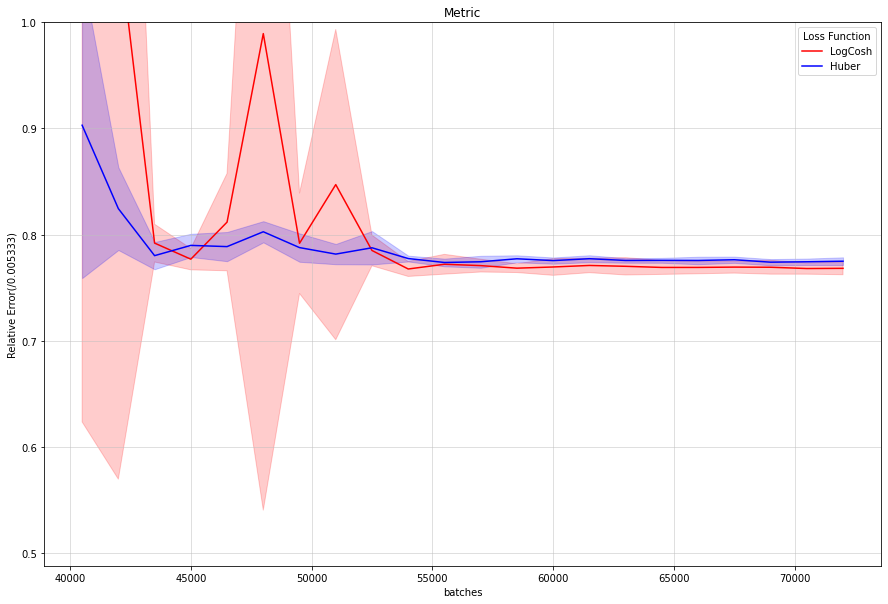

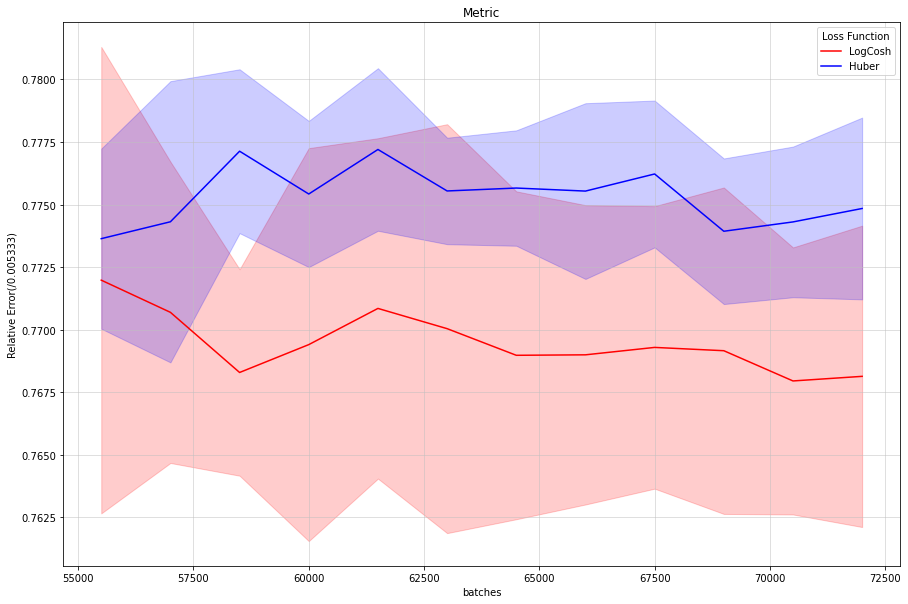